In [2]:
import pandas as pd

In [3]:
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"

df = pd.read_csv(url)

In [4]:
df[:10]

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
5,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
7,9,steven stewart,steven,stewart,2013-08-30,Male,1973-02-25,43,25 - 45,Other,...,3,Low,2013-08-30,2014-05-22,2014-06-03,3,0,265,0,0
8,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,...,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0
9,13,bo bradac,bo,bradac,2013-11-04,Male,1994-06-10,21,Less than 25,Caucasian,...,5,Medium,2013-11-04,2015-01-06,2015-01-07,1,0,428,1,1


In [5]:
df.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

*Hvilke kolonner skal vi velge?*

### Kolonnenes betydning

- **id:** ID-nummer.

- **name:** kandidatens fulle navn.

- **first:** fornavn.

- **last:** etternavn.

- **compas_screening_date:** dato for undersøkelse.

- **sex:** kjønn.

- **dob:** fødselsdato.

- **age:** alder.

- **age_cat:** alderkategori.

- **v_decile_score:**

- **v_score_text:**

- **v_screening_date:**

- **in_custody:** dato for ivaretektsfengsling

- **out_custody:** dato for løslatelse

- **priors_count.1:**

- **start:**

- **end:**

- **event:**

- **two_year_recid:** hvorvidt kandidaten begikk et nytt lovbrudd innen to år

<AxesSubplot:>

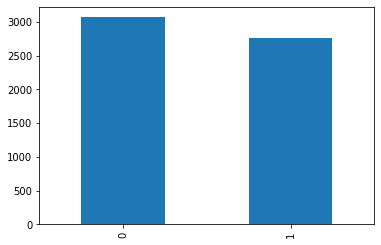

In [6]:
df_male = df[df["sex"] == "Male"]
df_female = df[df["sex"] == "Female"]
df_white = df[df["race"] == "Caucasian"]
df_black = df[df["race"] == "African-American"]
df_male["two_year_recid"].value_counts().plot(kind="bar")